## Assignment 9 - Monica Zhang
https://spark.apache.org/docs/latest/ml-features#lsh-operations  
https://databricks.com/blog/2017/05/09/detecting-abuse-scale-locality-sensitive-hashing-uber-engineering.html

In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

#### Add "eagerEval.enabled" to beautify the way Spark DF is displayed

In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
df = spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/monicazhang/final_project_eda_154M_2.parquet')

23/03/09 20:56:24 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
df.limit(5)

coordinates,created_at,favorite_count,favorited,filter_level,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,lang,place,quote_count,quoted_status,quoted_status_id,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,entities,extended_entities,extended_tweet,geo,place.country,place.full_name,place.name,place.place_type,user.id,user.name,user.screen_name,user.location,user.created_at,user.description,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,user.statuses_count,user.url,user.verified,retweets_count,user_type
null,Wed Nov 16 00:04:...,0,false,low,1592669785732489217,null,null,null,false,en,null,0,null,null,null,0,0,RT,yakubwudil,"{null, Tue Nov 15...","<a href=""http://t...",RT @yakubwudil: T...,1668557041949,false,The Scholarship p...,"{false, Wed Jan 2...","{[], null, [], []...",null,null,null,null,null,null,null,473627914,زهردين,Deen_______Yaro,Farakwai,Wed Jan 25 05:13:...,P.D.E📝 (In View)...,4086,1633,29,625975,373682,null,false,511,other
null,Wed Nov 16 00:04:...,0,false,low,1592669828372131840,aopaderf,1592669361244098561,848970475589914624,false,en,null,0,null,null,null,0,0,,TheCalvinCooli1 V...,null,"<a href=""https://...",@bestgtor88 @TheC...,1668557052115,true,@bestgtor88 @TheC...,"{false, Mon Apr 0...","{[], null, [], [{...",null,"{[29, 307], {[], ...",null,null,null,null,null,848970475589914624,What the freak is...,aopaderf,"Phoenix, AZ",Mon Apr 03 18:48:...,Pilot-instrument ...,955,1946,7,52966,28157,null,false,null,other
null,Wed Nov 16 00:04:...,0,false,low,1592669859833597953,null,null,null,false,en,null,0,null,null,null,0,0,RT,donsennen,"{null, Fri Nov 11...","<a href=""http://t...",RT @donsennen: Co...,1668557059616,false,Conestoga college...,"{false, Mon Jul 2...","{[], null, [], []...",null,null,null,null,null,null,null,1551472921176162309,Julius Gen,JuliusGen1,null,Mon Jul 25 07:43:...,null,35,491,0,1,41,null,false,77,other
null,Wed Nov 16 00:04:...,0,false,low,1592669879085277185,null,null,null,false,en,null,0,null,null,null,0,0,RT,latimes,"{null, Wed Nov 09...","<a href=""https://...",RT @latimes: Edit...,1668557064206,false,Editorial: A stri...,"{false, Sat Apr 1...","{[], null, [], []...",null,null,null,null,null,null,null,1251660359766888450,Philosophers' Links,philosophylinks,null,Sat Apr 18 23:54:...,Bot retweeting in...,563,1,8,3,214963,https://phlinks.h...,false,125,other
null,Wed Nov 16 00:04:...,0,false,low,1592669889734516736,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""http://p...","Low pay, rising c...",1668557066745,false,"Low pay, rising c...","{false, Wed Jul 2...","{[], null, [], [{...",null,null,null,null,null,null,null,1420342450279706629,Bloggancer,bloggancer,India,Wed Jul 28 11:16:...,Daily Trending News,13,5,0,5,44788,https://bloggance...,false,null,other


In [7]:
df = df.withColumn('hashtags', expr("entities.hashtags.text"))

In [8]:
df.limit(5)

coordinates,created_at,favorite_count,favorited,filter_level,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,lang,place,quote_count,quoted_status,quoted_status_id,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,entities,extended_entities,extended_tweet,geo,place.country,place.full_name,place.name,place.place_type,user.id,user.name,user.screen_name,user.location,user.created_at,user.description,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,user.statuses_count,user.url,user.verified,retweets_count,user_type,user_type_nv,hashtags
null,Mon Sep 26 08:47:...,0,false,low,1574319825777737728,null,null,null,false,en,null,0,null,null,null,0,0,RT,ushiebuaras,"{null, Sun Sep 25...","<a href=""http://t...",RT @ushiebuaras: ...,1664182070570,false,Interested in a M...,"{false, Tue Dec 1...","{[], null, [], []...",null,null,null,null,null,null,null,943102958492897280,Dr Leo Eze,ezebit2,"Lagos, Nigeria",Tue Dec 19 12:57:...,"Bitcoin saver, Me...",1248,996,19,2008,2024,null,false,88,other,other,[]
null,Mon Sep 26 08:47:...,0,false,low,1574319839149281280,null,null,null,true,en,null,0,"{null, Sat Sep 24...",1573804912265281537,why does the univ...,0,0,RT,JoshuaPotash,"{null, Mon Sep 26...","<a href=""https://...",RT @JoshuaPotash:...,1664182073758,false,People say free c...,"{false, Thu Oct 1...","{[], null, [], []...",null,null,null,null,null,null,null,1184946666832564224,Leyley,grlfromlebanon,null,Thu Oct 17 21:40:...,null,23,318,0,1344,696,null,false,5848,other,other,[]
null,Mon Sep 26 08:48:...,0,false,low,1574319955541008384,zppINFO,1574319951736979456,713945335,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""http://t...",post. The school ...,1664182101508,true,post. The school ...,"{false, Tue Jul 2...","{[], null, [], [{...",null,"{[0, 219], {[], n...",null,null,null,null,null,713945335,The Zimbabwe Peac...,zppINFO,Zimbabwe,Tue Jul 24 08:34:...,#WINNER | @CSR_I...,16109,1003,36,947,5485,http://www.zimpea...,false,null,other,other,[]
null,Mon Sep 26 08:49:...,0,false,low,1574320286933176321,null,null,null,false,en,null,0,null,null,null,0,0,,null,null,"<a href=""http://w...",#JobAlert new Tea...,1664182180518,true,#JobAlert new Tea...,"{false, Thu Oct 0...","{[{[0, 9], JobAle...",null,"{[0, 206], {[{[0,...",null,null,null,null,null,784004583890776064,Northants Teaching,Northants_Teach,Northamptonshire,Thu Oct 06 12:17:...,Recruiting except...,1500,638,6,2024,10192,http://www.teachn...,false,null,other,other,[JobAlert]
null,Mon Sep 26 08:49:...,0,false,low,1574320303726993409,null,null,null,true,en,null,0,"{null, Sat Sep 24...",1573804912265281537,why does the univ...,0,0,RT,JoshuaPotash,"{null, Mon Sep 26...","<a href=""https://...",RT @JoshuaPotash:...,1664182184522,false,People say free c...,"{false, Wed Nov 0...","{[], null, [], []...",null,null,null,null,null,null,null,796364661495136257,BoJess,bojess1984,"Edinburg, TX",Wed Nov 09 14:51:...,null,163,370,0,87267,46942,null,false,5857,other,other,[]


In [8]:
df.count()

1541655

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("example").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()

In [15]:
from pyspark.sql.functions import to_timestamp, date_format

# Convert the created_at column to a datetime format
df = df.withColumn("created_at", to_timestamp(df["created_at"], "EEE MMM dd HH:mm:ss ZZZZ yyyy"))

# Group the tweets by day and count the number of tweets in each group
tweets_per_date = df.groupBy(date_format("created_at", "yyyy-MM").alias("date")).count()

# Show the tweet counts per day
tweets_per_date.show()

+-------+------+
|   date| count|
+-------+------+
|2022-04|198898|
|2022-06|119158|
|2022-08|427035|
|2022-07| 90008|
|2023-02| 20309|
|2022-11|116809|
|2022-10|107247|
|2023-01| 94890|
|2022-09|127979|
|2022-05|162272|
|2022-12| 77050|
+-------+------+



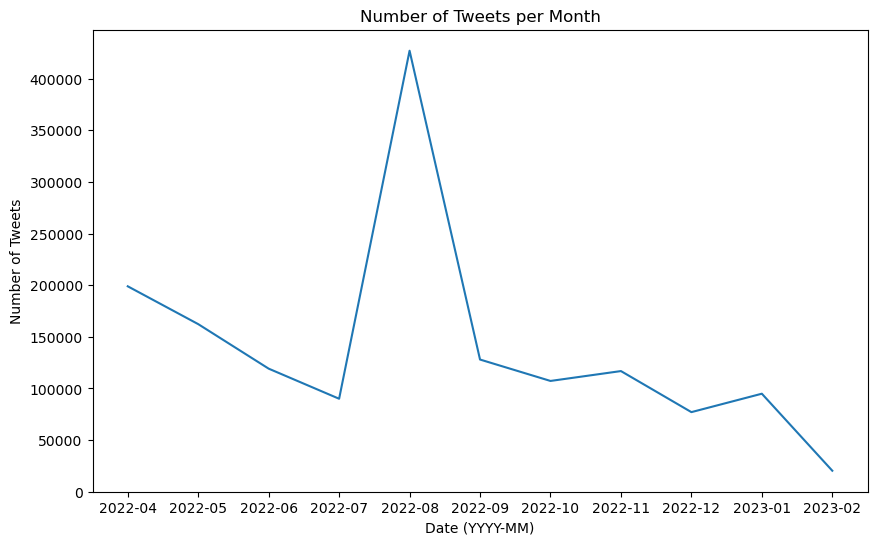

In [17]:
import matplotlib.pyplot as plt

# Extract x and y values from the DataFrame
tweets_per_date_sorted = tweets_per_date.orderBy('date')
x = tweets_per_date_sorted.select('date').rdd.flatMap(lambda x: x).collect()
y = tweets_per_date_sorted.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(x, y)
plt.title('Number of Tweets per Month')
plt.xlabel('Date (YYYY-MM)')
plt.ylabel('Number of Tweets')
plt.show()

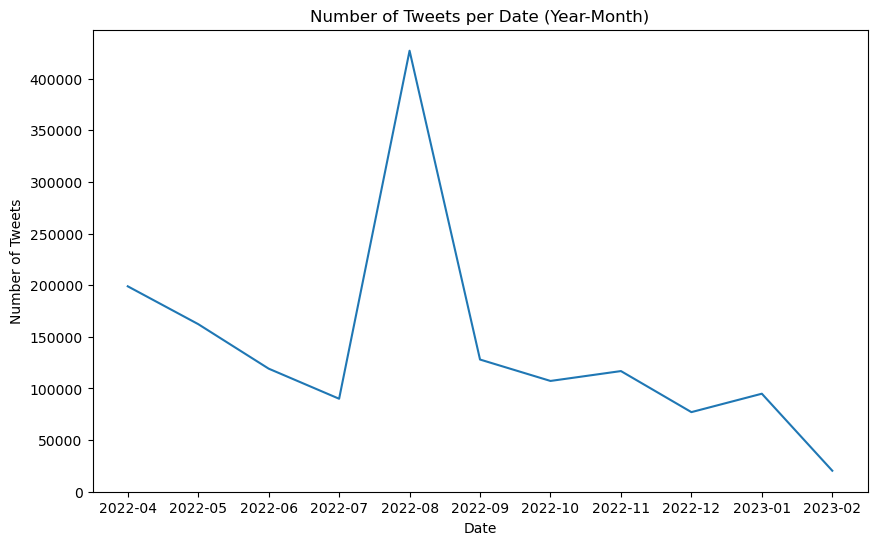

In [25]:
data = tweets_per_date.orderBy('date').collect()
x = [row.date for row in data]
y = [row['count'] for row in data]
plt.figure(figsize=(10, 6))

# Plot the data
plt.plot(x, y)
plt.title('Number of Tweets per Date (Year-Month)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

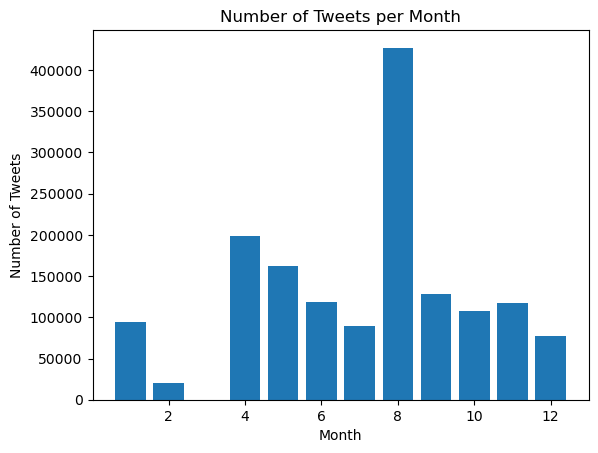

In [16]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Extract x and y values from the DataFrame
tweets_per_month = tweets_per_date.select(F.month('date').alias('month'), 'count')
x = tweets_per_month.select('month').rdd.flatMap(lambda x: x).collect()
y = tweets_per_month.select('count').rdd.flatMap(lambda x: x).collect()

# Convert x values to integers
x = list(map(int, x))

# Create bar chart
plt.bar(x, y)
plt.title('Number of Tweets per Month')
plt.xlabel('Month')
plt.ylabel('Number of Tweets')
plt.show()

In [12]:
from pyspark.sql.functions import to_timestamp, date_format

# Convert the created_at column to a datetime format
df = df.withColumn("created_at", to_timestamp(df["created_at"], "EEE MMM dd HH:mm:ss ZZZZ yyyy"))

# Group the tweets by day and count the number of tweets in each group
tweets_per_date = df.groupBy(date_format("created_at", "yyyy-MM-dd").alias("date")).count()

# Show the tweet counts per day
tweets_per_date.show()

+----------+-----+
|      date|count|
+----------+-----+
|2022-10-05| 3184|
|2023-01-21| 2677|
|2022-10-07| 3187|
|2022-05-17| 4156|
|2022-07-08| 2458|
|2022-07-04| 2122|
|2022-07-30| 2801|
|2022-09-03| 4281|
|2022-10-24| 3227|
|2022-07-23| 1598|
|2022-10-13| 2644|
|2022-11-23| 4216|
|2022-11-09| 3362|
|2022-10-29| 1589|
|2022-12-14| 2822|
|2022-11-04| 3688|
|2023-01-30| 2362|
|2022-06-01| 7391|
|2022-05-04| 8644|
|2022-11-27| 2589|
+----------+-----+
only showing top 20 rows



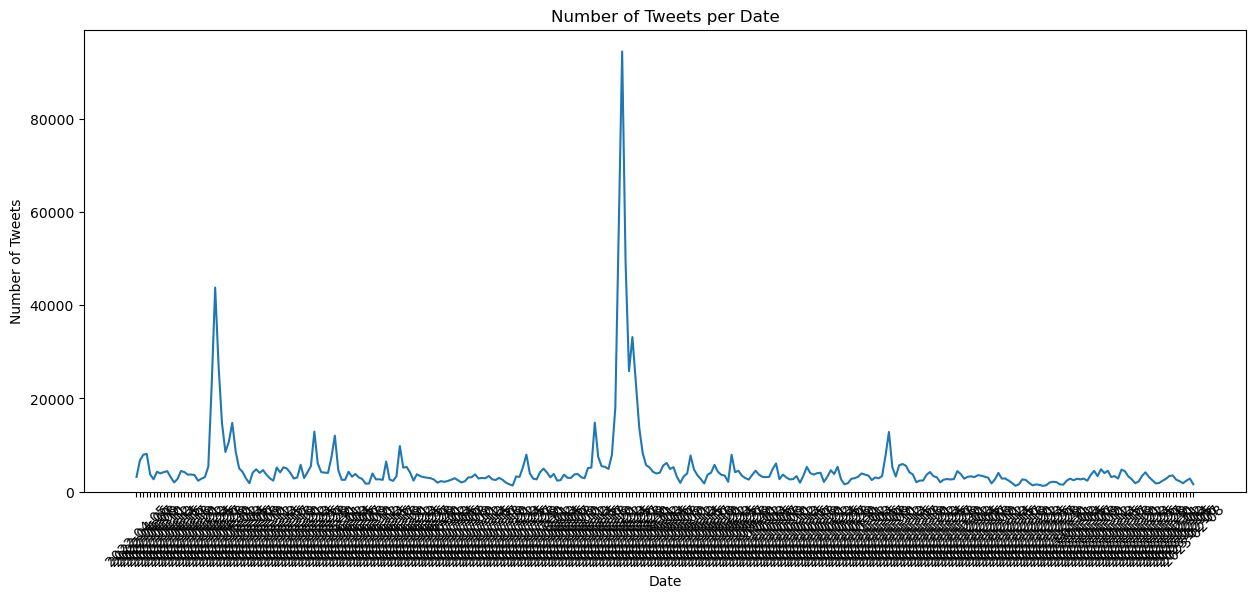

In [14]:
tweets_per_date_sorted = tweets_per_date.orderBy('date')
x = tweets_per_date_sorted.select('date').rdd.flatMap(lambda x: x).collect()
y = tweets_per_date_sorted.select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(15, 6))

# Plot the data
plt.plot(x, y)
plt.title('Number of Tweets per Date')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
plt.show()

Based on the chart, it appears that there may be some gaps in the data collection. There are several periods where the number of tweets per day drops significantly or goes to zero. It's possible that these gaps are due to technical issues with the data collection process or due to a lack of Twitter activity during those periods.

In [22]:
from pyspark.sql.functions import to_timestamp, date_format

# Convert the created_at column to a datetime format
df = df.withColumn("created_at", to_timestamp(df["created_at"], "EEE MMM dd HH:mm:ss ZZZZ yyyy"))

# Group the tweets by day and count the number of tweets in each group
tweets_per_date = df.groupBy(date_format("created_at", "yyyy-MM-dd").alias("date")).count()

# Show the tweet counts per day
tweets_per_date.show()

# Show the top 10 dates by tweet count
tweets_per_date.orderBy('count', ascending=False).limit(10).show()


+----------+-----+
|      date|count|
+----------+-----+
|2022-10-07| 3187|
|2022-05-17| 4156|
|2022-07-04| 2122|
|2022-07-08| 2458|
|2022-07-30| 2801|
|2022-09-03| 4281|
|2022-07-23| 1598|
|2022-11-23| 4216|
|2022-11-09| 3362|
|2022-12-14| 2822|
|2022-10-29| 1589|
|2022-05-04| 8644|
|2022-11-04| 3688|
|2023-01-30| 2362|
|2022-11-27| 2589|
|2022-09-07| 6165|
|2022-08-17|14825|
|2022-12-07| 3549|
|2023-01-05| 2789|
|2022-06-15| 2681|
+----------+-----+
only showing top 20 rows



+----------+-----+
|      date|count|
+----------+-----+
|2022-08-25|94436|
|2022-08-24|56432|
|2022-08-26|49241|
|2022-04-28|43796|
|2022-08-28|33175|
|2022-04-29|27038|
|2022-08-27|25870|
|2022-08-29|23540|
|2022-04-27|23108|
|2022-08-23|18012|
+----------+-----+



Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


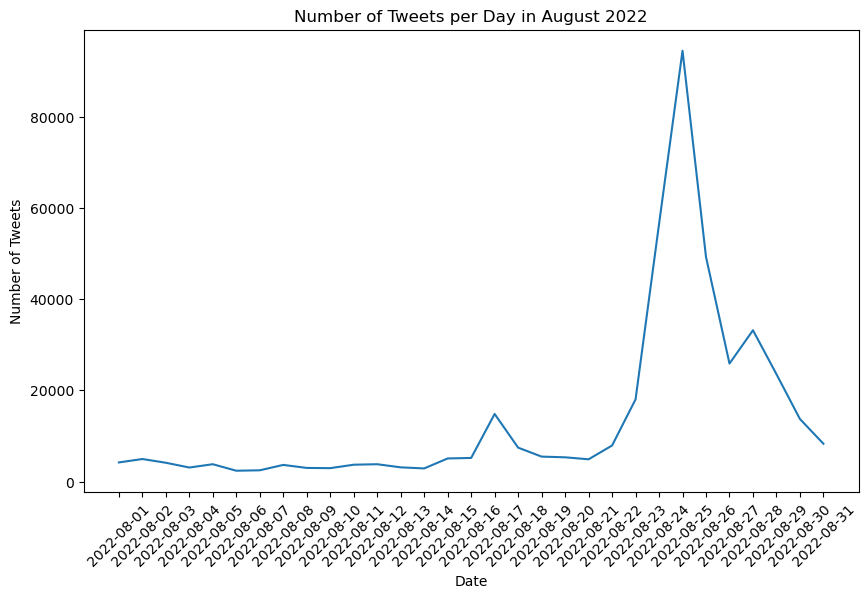

In [35]:
august_2022_tweets = df.filter((F.year("created_at") == 2022) & (F.month("created_at") == 8))

# Group the tweets by day and count the number of tweets in each group
tweets_per_day = august_2022_tweets.groupBy(date_format("created_at", "yyyy-MM-dd").alias("date")).count()

# Order the DataFrame by date
tweets_per_day = tweets_per_day.orderBy('date')

# Extract x and y values from the DataFrame
x = [row['date'] for row in tweets_per_day.collect()]
y = [row['count'] for row in tweets_per_day.collect()]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Number of Tweets per Day in August 2022')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()


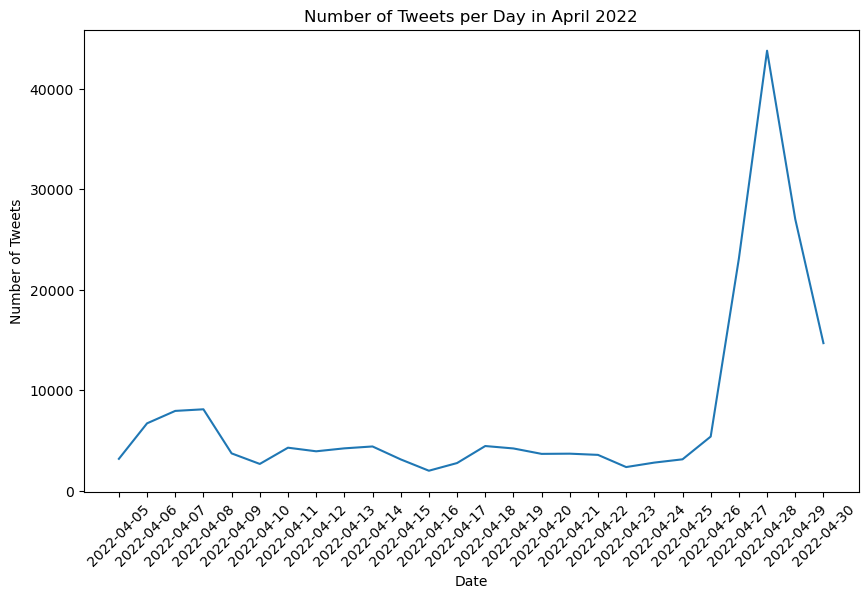

In [37]:
april_2022_tweets = df.filter((F.year("created_at") == 2022) & (F.month("created_at") == 4))

# Group the tweets by day and count the number of tweets in each group
tweets_per_day = april_2022_tweets.groupBy(date_format("created_at", "yyyy-MM-dd").alias("date")).count()

# Order the DataFrame by date
tweets_per_day = tweets_per_day.orderBy('date')

# Extract x and y values from the DataFrame
x = [row['date'] for row in tweets_per_day.collect()]
y = [row['count'] for row in tweets_per_day.collect()]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.title('Number of Tweets per Day in April 2022')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

In [ ]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")